# "Global sales" model

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from tensorflow import keras

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

/Users/tyler/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
game_sales_ml_df = pd.read_csv("data/game_sales_ml.csv")

game_sales_ml_df.head()

,Name,Platform,Publisher,Genre,Rating,Year of Release,Critic Score,User Score,NA Sales,EU Sales,JP Sales,Other Sales,Global Sales
0,Wii Sports,Wii,Nintendo,Sports,E,2006,76.0,8.0,41.36,28.96,3.77,8.45,82.53
1,Mario Kart Wii,Wii,Nintendo,Racing,E,2008,82.0,8.3,15.68,12.76,3.79,3.29,35.52
2,Wii Sports Resort,Wii,Nintendo,Sports,E,2009,80.0,8.0,15.61,10.93,3.28,2.95,32.77
3,New Super Mario Bros.,DS,Nintendo,Platform,E,2006,89.0,8.5,11.28,9.14,6.50,2.88,29.80
4,Wii Play,Wii,Nintendo,Misc,E,2006,58.0,6.6,13.96,9.18,2.93,2.84,28.92


## Data preprocessing

In [3]:
model_df = game_sales_ml_df.copy()

model_df.head()

,Name,Platform,Publisher,Genre,Rating,Year of Release,Critic Score,User Score,NA Sales,EU Sales,JP Sales,Other Sales,Global Sales
0,Wii Sports,Wii,Nintendo,Sports,E,2006,76.0,8.0,41.36,28.96,3.77,8.45,82.53
1,Mario Kart Wii,Wii,Nintendo,Racing,E,2008,82.0,8.3,15.68,12.76,3.79,3.29,35.52
2,Wii Sports Resort,Wii,Nintendo,Sports,E,2009,80.0,8.0,15.61,10.93,3.28,2.95,32.77
3,New Super Mario Bros.,DS,Nintendo,Platform,E,2006,89.0,8.5,11.28,9.14,6.50,2.88,29.80
4,Wii Play,Wii,Nintendo,Misc,E,2006,58.0,6.6,13.96,9.18,2.93,2.84,28.92


### Handling categorical data

In [4]:
# NEW DATA: model_df[["name", "platform", "Genre", "Publisher", "Developer", "Rating"]].nunique()
model_df[["Name", "Platform", "Publisher", "Genre", "Rating"]].nunique()

Name         4428
Platform       17
Publisher     271
Genre          12
Rating          8
dtype: int64

In [5]:
unnecessary_columns = ["Name"] # too many of them
onehot_encode_columns = ["Platform", "Genre", "Rating"] # <=50 of them
label_encode_columns = ["Publisher"] # >50 of them

In [6]:
# unnecessary columns
model_df = model_df.drop(columns=unnecessary_columns)

# one-hot encode columns
model_df = pd.get_dummies(model_df, columns=onehot_encode_columns)

# label encode columns
label_encoder = LabelEncoder()
for label_encode_column in label_encode_columns:
    model_df[label_encode_column] = label_encoder.fit_transform(model_df[label_encode_column])

In [7]:
model_df.head()

,Publisher,Year of Release,Critic Score,User Score,NA Sales,EU Sales,JP Sales,Other Sales,Global Sales,Platform_3DS,...,Genre_Sports,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_K-A,Rating_M,Rating_RP,Rating_T,Rating_Unknown
0,167,2006,76.0,8.0,41.36,28.96,3.77,8.45,82.53,False,...,True,False,False,True,False,False,False,False,False,False
1,167,2008,82.0,8.3,15.68,12.76,3.79,3.29,35.52,False,...,False,False,False,True,False,False,False,False,False,False
2,167,2009,80.0,8.0,15.61,10.93,3.28,2.95,32.77,False,...,True,False,False,True,False,False,False,False,False,False
3,167,2006,89.0,8.5,11.28,9.14,6.50,2.88,29.80,False,...,False,False,False,True,False,False,False,False,False,False
4,167,2006,58.0,6.6,13.96,9.18,2.93,2.84,28.92,False,...,False,False,False,True,False,False,False,False,False,False


## Modeling: Neural Network

### Selecting the target (y) and features (X)

In [8]:
y = model_df["Global Sales"] # target
X = model_df.drop(columns=["Global Sales"]) # features

### Splitting the data: 80% training and 20% testing

In [9]:
X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=.20, random_state=42)

In [10]:
scaler = StandardScaler() # mean=0, standard_deviation=1

X_training = scaler.fit_transform(X_training)
X_testing = scaler.fit_transform(X_testing)

### Building the model

In [11]:
model_neuralnetwork = keras.Sequential(
    [
        # layer 1
        keras.layers.Dense(128, activation="relu", input_shape=(X_training.shape[1],)),
        # layer 2
        keras.layers.Dense(64, activation="relu"),
        # layer 3
        keras.layers.Dense(32, activation="relu"),
        # output layer
        keras.layers.Dense(1)
    ]
)

model_neuralnetwork.compile(optimizer="adam", loss="mean_squared_error", metrics=[keras.metrics.RootMeanSquaredError()])

/Users/tyler/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Training and evaluating the model

In [12]:
model_neuralnetwork.fit(X_training, y_training, epochs=50, batch_size=32, validation_data=(X_testing, y_testing))

Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5640 - root_mean_squared_error: 1.7997 - val_loss: 0.1486 - val_root_mean_squared_error: 0.3855
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0649 - root_mean_squared_error: 0.2536 - val_loss: 0.1608 - val_root_mean_squared_error: 0.4010
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0401 - root_mean_squared_error: 0.1953 - val_loss: 0.0719 - val_root_mean_squared_error: 0.2681
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.0311 - root_mean_squared_error: 0.1743 - val_loss: 0.0843 - val_root_mean_squared_error: 0.2903
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.0101 - root_mean_squared_error: 0.1002 - val_loss: 0.1278 - val_root_mean_squared_error: 0.3575
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.1575 - val_root_mean_squared_error: 0.3969
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s

In [13]:
model_neuralnetwork.evaluate(X_testing, y_testing)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 0.0743 - root_mean_squared_error: 0.2689


[0.09593234956264496, 0.3097294867038727]

### Predicting

In [14]:
y_neutralnetwork_prediction = model_neuralnetwork.predict(X_testing)

r2_neuralnetwork = r2_score(y_testing, y_neutralnetwork_prediction)
print(f"r2_neuralnetwork: {r2_neuralnetwork}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
r2_neuralnetwork: 0.9646964596785949


## Modeling: Linear

In [15]:
# building
model_linear = LinearRegression()

# training
model_linear.fit(X_training, y_training)

# predicting
y_linear_prediction = model_linear.predict(X_testing)

r2_linear = r2_score(y_testing, y_linear_prediction)
print(f"r2_linear: {r2_linear}")

r2_linear: 0.9617913276231421


## Modeling: Tree

In [16]:
# building
model_randomforest = RandomForestRegressor(random_state=42)

# training
model_randomforest.fit(X_training, y_training)

# predicting
y_randomforest_prediction = model_randomforest.predict(X_testing)

r2_randomforest = r2_score(y_testing, y_randomforest_prediction)
print(f"r2_randomforest: {r2_randomforest}")

r2_randomforest: 0.9433796525543025


## Saving

### Data

In [ ]:
model_df.to_csv("models/global_sales_model_data.csv", index=False)

### Models

In [18]:
with open("models/global_sales_model_neuralnetwork.pkl", "wb") as file:
    pickle.dump(model_neuralnetwork, file)

In [19]:
with open("models/global_sales_model_linear.pkl", "wb") as file:
    pickle.dump(model_linear, file)

with open("models/global_sales_model_randomforest.pkl", "wb") as file:
    pickle.dump(model_randomforest, file)

### Images

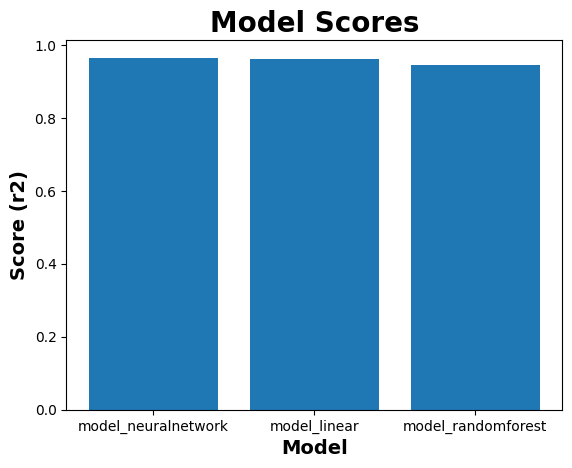

In [20]:
# data
models = ["model_neuralnetwork", "model_linear", "model_randomforest"]
scores = [r2_neuralnetwork, r2_linear, r2_randomforest]

# plotting
plt.bar(models, scores)

# formatting
plt.title("Model Scores", fontsize=20, fontweight="bold")
plt.xlabel("Model", fontsize=14, fontweight="bold")
plt.ylabel("Score (r2)", fontsize=14, fontweight="bold")

# saving / showing
plt.savefig("visuals/Model-Scores.jpg")
plt.show()